# Recursion Unpacked: A Gentle Guide, with Quicksort as Our Star

Hey! Recursion can feel magical at first—like the code is calling *itself* to solve the problem—but it's really just a clever way to break big tasks into smaller, identical ones. Since we've been geeking out on Quicksort, let's use it as our playground: Its recursion is the heart of the algorithm, and understanding it explains why balance matters so much (and why Python's default recursion limit is 1000—hint: skewed splits can crash you!).

Think of recursion like Russian nesting dolls: Each doll (function call) opens to reveal a smaller one inside, until you hit the tiniest (base case). To reassemble, you work backward. No infinite dolls, or boom—stack overflow!

---

## Step 1: Recursion 101—What It Is and Why It Rocks
### 1.1: The Two-Piece Puzzle
Every recursive function needs **exactly two things**:
- **Base Case**: "I'm small enough—stop recursing and return a simple answer." (E.g., if size ≤1, sorted!)
- **Recursive Case**: "I'm big—solve smaller versions of me, then combine results." (E.g., partition → recurse left + recurse right → done.)

**Toy Example: Factorial (n! = n × (n-1)! )**
```python
def factorial(n):
    if n <= 1:  # Base case
        return 1
    else:       # Recursive case
        return n * factorial(n - 1)  # Call self with smaller n
```
- Call `factorial(4)`:
  1. 4 >1 → return 4 * factorial(3)
  2. 3 >1 → return 3 * factorial(2)  **(stack: two calls waiting)**
  3. 2 >1 → return 2 * factorial(1)
  4. 1 ≤1 → return 1  *(base hit!)*
  5. Unwind: $2*1=2$ → $3*2=6$ → $4*6=24$
- **Magic**: No loops needed—self-similarity handles the repetition.

**Intuition**: Like a chain of promises: "I'll compute once the smaller one does." Elegant for trees/graphs/divide-conquer.

### 1.2: Under the Hood—The Call Stack
Recursion uses the **call stack** (a LIFO pile in memory):
- Each call pushes a **stack frame**: Local vars, params, return address ("resume here when done").
- Base case pops the top frame (returns).
- Deep recursion? Stack grows tall—risk overflow if too deep (Python: ~1000 frames default; C: stack size limit).

**Visual**: Imagine stacking plates (frames). Add factorial(4):
- Plate1: factorial(4), waiting for 3
- Plate2: factorial(3), waiting for 2
- Plate3: factorial(2), waiting for 1
- Plate4: factorial(1) → eat (base) → clear plate4, pass result up.
Plates = memory used; too many = crash.

**Pro Tip**: Tail recursion (recursive call *last*, result passed up) can optimize to loops (no stack growth)—but Python doesn't auto-optimize it.

---

## Step 2: Recursion in Quicksort—From Elegant to Explosive
Quicksort's recurrence $T(n) = T(\text{left}) + T(\text{right}) + O(n)$ is pure recursion:
```python
def quicksort(arr, low=0, high=None):
    if high is None:
        high = len(arr) - 1
    if low >= high:  # Base: 0 or 1 element
        return  # Sorted!
    
    # Partition: Pick pivot, rearrange (O(n) work)
    pivot_idx = partition(arr, low, high)  # Say, random or median-of-3
    
    # Recursive cases: Conquer subs
    quicksort(arr, low, pivot_idx - 1)    # Left
    quicksort(arr, pivot_idx + 1, high)   # Right
    # Unwind: No combine needed (in-place!)
```
- **Base**: Single/empty subarray—no work.
- **Recursive**: Two calls on smaller slices. Stack frames hold `low/high` bounds.
- **Unwind**: Returns bubble up, but since in-place, no extra merge.

### 2.1: Balanced Recursion—Shallow Stack, Happy Times
With good pivots (e.g., median-of-3, ~50/50 splits):
- Tree bushy: Max depth ~log₂ n (e.g., n=1M → ~20 frames).
- Stack *peak* = max depth (one path at a time; branches sequential).
- Memory: O(log n) frames → negligible (each frame ~few bytes for indices).

**Intuition**: Like a wide pyramid—stack never towers high.

### 2.2: Skewed Recursion—Deep Stack, Drama Ensues
Worst pivots (always min/max: 0/(n-1) splits):
- Tree = chain: Depth n (e.g., n=1000 → 1000 frames).
- Stack *peak* = n → Overflow! (Python: RecursionError at ~1000).
- Memory: O(n) frames → Stack overflow (OS kills process).

**Real Pitfall**: Even average case with random pivots: Occasional deep paths (e.g., 10% chance of bad split) can hit limit for huge n. Solution: Increase `sys.setrecursionlimit(10000)` (risky—segfaults) or iterate (stackless).


### 2.3: Measuring the Beast—Depth, Stack, Memory
- **Depth**: Max recursion levels (log n good, n bad).
- **Stack Size**: # active frames at peak (≈ max depth for Quicksort, since sequential).
- **Memory**: Bytes for frames (vars + overhead). Grows linear with depth.

**Bottom Line**: Recursion shines for natural hierarchies (trees, sorts) but watch the stack—it's finite! Quicksort's genius: Probabilistic balance keeps it shallow.

Questions so far? Like "Why not always iterative?" (Recursion clearer for uneven splits.) Now, let's *see* it with plots...

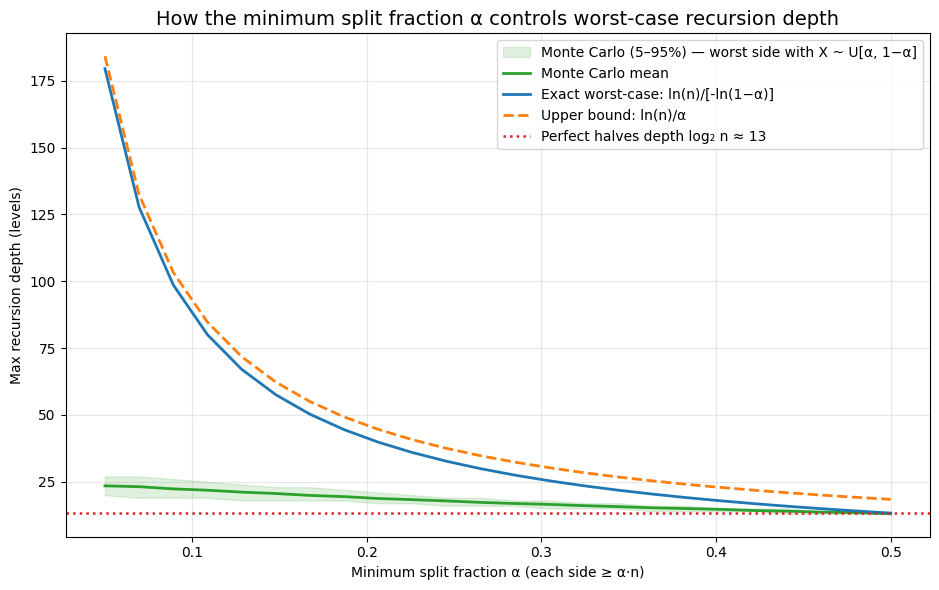

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------- Models --------------------------
def depth_exact(n, alpha):
    """Exact worst-case depth under an α-balance guarantee: ln(n)/-ln(1-α)."""
    alpha = np.asarray(alpha, dtype=float)
    return np.log(n) / (-np.log(1.0 - alpha))

def depth_upper_1_over_alpha(n, alpha):
    """Classical smooth upper bound: -ln(1-α) ≥ α ⇒ d ≤ ln(n)/α."""
    alpha = np.asarray(alpha, dtype=float)
    return np.log(n) / np.maximum(alpha, 1e-12)

def simulate_max_depth_worst_alpha_balanced(n, alpha, trials=200, rng=None):
    """
    Monte Carlo worst-case depth with α-balance:
    At each level draw X ~ Uniform([α, 1-α]) and recurse into the larger side.
    Stop when size <= 1.
    """
    if rng is None:
        rng = np.random.default_rng(123)
    depths = []
    for _ in range(trials):
        size = n
        depth = 0
        while size > 1:
            x = rng.uniform(alpha, 1.0 - alpha)
            total = size - 1
            left = int(np.floor(x * total))
            right = total - left
            size = max(left, right)  # worst side
            depth += 1
        depths.append(depth)
    depths = np.array(depths, dtype=float)
    return depths.mean(), np.percentile(depths, 5), np.percentile(depths, 95)

# -------------------------- Parameters --------------------------
n = 10_000
alpha_grid = np.linspace(0.05, 0.5, 24)
trials = 300
rng = np.random.default_rng(123)

# -------------------------- Curves --------------------------
d_exact = depth_exact(n, alpha_grid)
d_upper = depth_upper_1_over_alpha(n, alpha_grid)

sim_mean = np.zeros_like(alpha_grid)
sim_p5  = np.zeros_like(alpha_grid)
sim_p95 = np.zeros_like(alpha_grid)

for i, a in enumerate(alpha_grid):
    m, p5, p95 = simulate_max_depth_worst_alpha_balanced(n, a, trials=trials, rng=rng)
    sim_mean[i], sim_p5[i], sim_p95[i] = m, p5, p95

d_balanced = np.log2(n)

# -------------------------- Plot --------------------------
plt.figure(figsize=(9.5, 6.0))

# Simulation band and mean
plt.fill_between(alpha_grid, sim_p5, sim_p95, color="tab:green", alpha=0.15,
                 label="Monte Carlo (5–95%) — worst side with X ~ U[α, 1−α]")
plt.plot(alpha_grid, sim_mean, color="tab:green", lw=2, label="Monte Carlo mean")

# Exact and 1/α curves
plt.plot(alpha_grid, d_exact, color="tab:blue", lw=2,
         label="Exact worst-case: ln(n)/[-ln(1−α)]")
plt.plot(alpha_grid, d_upper, color="tab:orange", lw=2, ls="--",
         label="Upper bound: ln(n)/α")

# Balanced reference
plt.axhline(d_balanced, color="tab:red", ls=":", lw=1.8,
            label=f"Perfect halves depth log₂ n ≈ {d_balanced:.0f}")

# Use Unicode in axis labels to dodge mathtext parsing:
plt.xlabel("Minimum split fraction α (each side ≥ α·n)")
plt.ylabel("Max recursion depth (levels)")
plt.title("How the minimum split fraction α controls worst-case recursion depth", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc="upper right")

# tight_layout can choke if any text triggers mathtext parsing issues; guard it
try:
    plt.tight_layout()
except Exception:
    pass

plt.show()


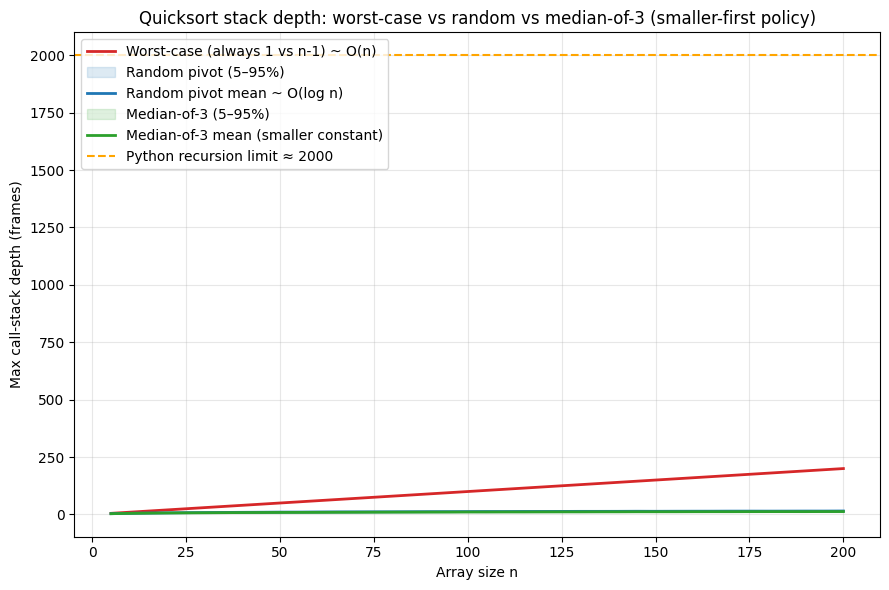

n = 200
  Worst-case depth: 200 (Θ(n))
  Random pivot mean depth: 15.19 (≈ c·log n)
  Median-of-3 mean depth: 12.71 (smaller c)


In [20]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Pivot quantile samplers (fraction of items to the LEFT)
# ============================================================

def sample_uniform():
    # Random pivot among n items ~ continuous Uniform(0,1) quantile
    return np.random.rand()

def sample_beta_2_2():
    # Median-of-3 approx: quantile ~ Beta(2,2)
    return np.random.beta(2, 2)

# ============================================================
# Stack-depth simulation (no real recursion)
# We model: subarray size n; pick pivot -> sizes (L, R) with L+R = n-1
# Policy: recurse "smaller-first" to reflect the common tail-recursion trick.
# This keeps stack usage ~ O(log n) in practice even if pivots vary.
# ============================================================

def max_stack_depth(n: int, sampler, policy: str = "smaller-first", rng=None) -> int:
    """
    Return the maximum call-stack depth that a quicksort-like recursion would use
    if we always recurse on one side, then tail-call the other.

    n: size of the input
    sampler: function returning a quantile x in (0,1), the fraction that goes left
    policy: "smaller-first" or "larger-first" (larger-first shows worse stacks)
    """
    if rng is None:
        rng = np.random

    # simulate call stack manually as (size, depth)
    stack = [(n, 1)]
    max_depth = 0

    while stack:
        size, depth = stack.pop()
        max_depth = max(max_depth, depth)
        if size <= 1:
            continue

        # choose pivot quantile and split sizes
        x = float(sampler())
        # Partition leaves size-1 elements split between left and right
        total = size - 1
        # Use a stable split to integers:
        # left = floor(x * total), right = total - left
        left = int(math.floor(x * total))
        right = total - left

        if policy == "smaller-first":
            a, b = sorted((left, right))          # (smaller, larger)
        elif policy == "larger-first":
            a, b = sorted((left, right), reverse=True)
        else:
            # default: smaller-first
            a, b = sorted((left, right))

        # Recurse on smaller first (push smaller with +1 depth),
        # then tail-call on larger (simulate by pushing too; order controls peak).
        if a > 0:
            stack.append((a, depth + 1))
        if b > 0:
            stack.append((b, depth + 1))

    return max_depth

# ============================================================
# Convenience wrappers
# ============================================================

def worst_case_depth(n: int) -> int:
    # Always 1 vs n-1 → depth exactly n (if you recurse into the n-1 side first)
    return n

def curve_mean_band(n_values, sampler, trials=200, policy="smaller-first"):
    means, p5, p95 = [], [], []
    for n in n_values:
        ds = [max_stack_depth(n, sampler, policy=policy) for _ in range(trials)]
        means.append(np.mean(ds))
        p5.append(np.percentile(ds, 5))
        p95.append(np.percentile(ds, 95))
    return np.array(means), np.array(p5), np.array(p95)

# ============================================================
# Parameters and runs
# ============================================================

np.random.seed(42)
n_max = 200
n_values = np.arange(5, n_max + 1, 5)  # sample every 5 for speed
trials = 300

# 1) Worst-case (analytical)
worst_curve = n_values.copy()  # depth ~ n

# 2) Random pivot + smaller-first
rand_mean, rand_p5, rand_p95 = curve_mean_band(n_values, sample_uniform, trials=trials, policy="smaller-first")

# 3) Median-of-3 + smaller-first
med3_mean, med3_p5, med3_p95 = curve_mean_band(n_values, sample_beta_2_2, trials=trials, policy="smaller-first")

# ============================================================
# Plotting
# ============================================================

fig, ax = plt.subplots(1, 1, figsize=(9, 6))

# Worst-case line
ax.plot(n_values, worst_curve, color="tab:red", lw=2, label="Worst-case (always 1 vs n-1) ~ O(n)")

# Random pivot band and mean
ax.fill_between(n_values, rand_p5, rand_p95, color="tab:blue", alpha=0.15, label="Random pivot (5–95%)")
ax.plot(n_values, rand_mean, color="tab:blue", lw=2, label="Random pivot mean ~ O(log n)")

# Median-of-3 band and mean
ax.fill_between(n_values, med3_p5, med3_p95, color="tab:green", alpha=0.15, label="Median-of-3 (5–95%)")
ax.plot(n_values, med3_mean, color="tab:green", lw=2, label="Median-of-3 mean (smaller constant)")

# Recursion limit reference
ax.axhline(sys.getrecursionlimit(), color="orange", ls="--", lw=1.5,
           label=f"Python recursion limit ≈ {sys.getrecursionlimit()}")

ax.set_xlabel("Array size n")
ax.set_ylabel("Max call-stack depth (frames)")
ax.set_title("Quicksort stack depth: worst-case vs random vs median-of-3 (smaller-first policy)")
ax.grid(True, alpha=0.3)
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()

# ============================================================
# Print quick summaries at n = n_max
# ============================================================

print(f"n = {n_max}")
print(f"  Worst-case depth: {worst_case_depth(n_max)} (Θ(n))")
print(f"  Random pivot mean depth: {rand_mean[-1]:.2f} (≈ c·log n)")
print(f"  Median-of-3 mean depth: {med3_mean[-1]:.2f} (smaller c)")


Skewed depth: 800, Balanced depth: 12 (~log2 N)
Per-frame payload: 2048 bytes
Skewed peak traced heap: 1,735,685 bytes (~2170 bytes/frame)
Balanced peak traced heap: 230,809 bytes (~19234 bytes/frame)


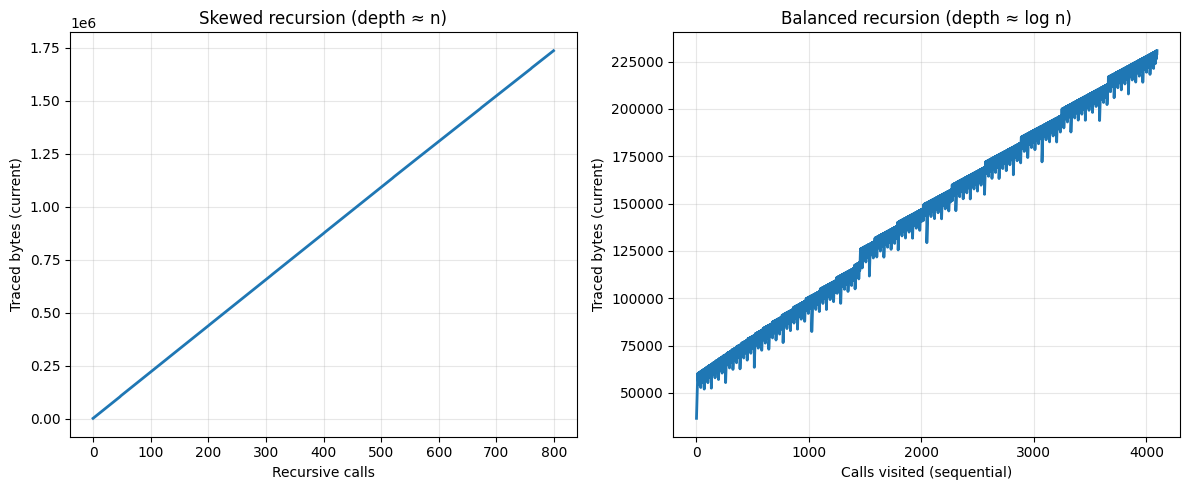

In [19]:
import sys
import math
import tracemalloc
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# Parameters
# ---------------------------------------------------------------------
N = 2**12                 # pretend "problem size"
DEPTH_SKEWED = min(800, N)              # make sure we don't hit recursion limit
DEPTH_BAL = int(math.log2(N))           # ~ log2(N) depth
PAYLOAD_PER_FRAME = 2048                # bytes allocated per frame (visible to tracemalloc)
SEED = 42

# Make sure recursion limit is high enough for the skewed demo
sys.setrecursionlimit(max(2000, DEPTH_SKEWED + 100))

# ---------------------------------------------------------------------
# Helpers: record traced-heap usage each time we enter a frame
# ---------------------------------------------------------------------
def snap_usage(store):
    current, peak = tracemalloc.get_traced_memory()
    store.append(current)

def skewed_rec(depth, store):
    """Linear-depth recursion; allocates PAYLOAD_PER_FRAME bytes per frame."""
    if depth == 0:
        return 1
    buf = bytearray(PAYLOAD_PER_FRAME)  # visible to tracemalloc
    snap_usage(store)
    return 1 + skewed_rec(depth - 1, store)

def balanced_rec(depth, store):
    """Binary recursion but bounded stack depth 'depth' (≈ log N).
    We call left then right; the *stack* never exceeds 'depth'.
    """
    if depth == 0:
        return 1
    buf = bytearray(PAYLOAD_PER_FRAME)  # visible to tracemalloc
    snap_usage(store)
    # Two branches executed sequentially; stack peak remains 'depth'
    left = balanced_rec(depth - 1, store)
    right = balanced_rec(depth - 1, store)
    return 1 + left + right

# ---------------------------------------------------------------------
# Run measurements
# ---------------------------------------------------------------------
tracemalloc.start()

skew_samples = []
_ = skewed_rec(DEPTH_SKEWED, skew_samples)
skew_current, skew_peak = tracemalloc.get_traced_memory()

# Reset stats between experiments for clarity
tracemalloc.reset_peak()

bal_samples = []
_ = balanced_rec(DEPTH_BAL, bal_samples)
bal_current, bal_peak = tracemalloc.get_traced_memory()

tracemalloc.stop()

# ---------------------------------------------------------------------
# Report
# ---------------------------------------------------------------------
print(f"Skewed depth: {DEPTH_SKEWED}, Balanced depth: {DEPTH_BAL} (~log2 N)")
print(f"Per-frame payload: {PAYLOAD_PER_FRAME} bytes")
print(f"Skewed peak traced heap: {skew_peak:,.0f} bytes "
      f"(~{skew_peak/max(1,DEPTH_SKEWED):.0f} bytes/frame)")
print(f"Balanced peak traced heap: {bal_peak:,.0f} bytes "
      f"(~{bal_peak/max(1,DEPTH_BAL):.0f} bytes/frame)")

# ---------------------------------------------------------------------
# Plots
# ---------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(np.arange(len(skew_samples)), skew_samples, lw=2)
axes[0].set_title("Skewed recursion (depth ≈ n)")
axes[0].set_xlabel("Recursive calls")
axes[0].set_ylabel("Traced bytes (current)")
axes[0].grid(True, alpha=0.3)

axes[1].plot(np.arange(len(bal_samples)), bal_samples, lw=2)
axes[1].set_title("Balanced recursion (depth ≈ log n)")
axes[1].set_xlabel("Calls visited (sequential)")
axes[1].set_ylabel("Traced bytes (current)")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


---

# Partitioning

# Partitioning Schemes in Quicksort: Lomuto vs. Hoare—A Hands-On Guide

Hey! We've journeyed through Quicksort's big ideas—balance, recursion trees—but now let's zoom *inside* the engine: the **partition** step. This is where the magic (and sweat) happens: Rearrange the array so all ≤ pivot go left, all > pivot go right. The pivot ends up in its "final" spot, and we recurse on the sides.

Why care? Partitioning is O(n) work but must be **in-place** (no extra arrays) and **efficient** (few swaps). Two classics: **Lomuto** (simple, one-pointer) and **Hoare** (faster, two-pointers). We'll unpack each pedagogically: Intuition first, then code with step-by-step prints, then a trace on a toy array. By the end, you'll code your own and spot why Hoare edges out in speed.

Think of partitioning like sorting kids by height around a line (pivot): Lomuto is like a single usher scanning left-to-right; Hoare is two ushers starting from ends, meeting in the middle.

We'll use this array for traces: `arr = [3, 1, 4, 1, 5, 9, 2, 6, 5, 3, 5]` (n=11, pivot=5, unsorted mess). Sorted: [1,1,2,3,3,4,5,5,5,6,9]. Expect left: ≤5, right: >5, pivot at index ~6 (three 5's).

---

## Step 1: Partitioning Basics—What We're Aiming For
In Quicksort's core:
1. Pick pivot (e.g., last element, or median-of-3).
2. **Partition**: Rearrange subarray `arr[low..high]` so:
   - All `arr[low..pivot_idx-1]` ≤ pivot.
   - All `arr[pivot_idx+1..high]` > pivot.
   - `arr[pivot_idx]` == pivot (its sorted spot).
3. Recurse: `quicksort(low, pivot_idx-1)` + `quicksort(pivot_idx+1, high)`.

**Key Rules**:
- In-place: Swap elements, no temp array.
- Stable? Nah—order doesn't matter for sort.
- Cost: O(n) time (scan once), O(1) space.

Both schemes assume pivot is `arr[high]` (Lomuto) or swapped to end first (Hoare). 

Output: Pivot index for recursion.

**Intuition**: Like bubbling the pivot to its place via swaps, while herding smalls left, larges right.

---

## Part A: Lomuto Partitioning—Simple, Like a Single Sweep
Named after Nico Lomuto (1980s). **One pointer** (`i`) tracks the "wall" of small elements. We scan from left (`j`), swapping when we find a small.

### A1: Intuition Step by Step
Imagine the array as a line: Left = "≤ pivot" zone (growing), right = unknown/untouched.
1. Start: `i = low - 1` (wall just before start).
2. Scan `j` from `low` to `high-1` (skip pivot at end).
3. For each `j`:
   - If `arr[j] ≤ pivot`: Swap with `arr[i+1]` (extend wall), increment `i`.
   - Else: Skip (leave for right side).
4. After scan: Swap pivot (`arr[high]`) with `arr[i+1]` (wall end)—pivot settles.
5. Return `i+1` (pivot spot).

**Why It Works**: Every small found "crosses" to left of wall; larges stay right. Final swap places pivot exactly after all smalls.

**Pros**: Easy to code/debug (one loop). Handles duplicates fine.

**Cons**: O(n) swaps worst-case (many smalls late).

---

## Part B: Hoare Partitioning—Faster, Like a Pincer Move
Charles Hoare's original (1961). **Two pointers** (`left`, `right`) start at ends, cross when they find misplacements, swap, repeat till they meet.

### B1: Intuition Step by Step
Like two searchers: One from left hunting larges (>pivot), one from right hunting smalls (≤pivot). When both find one, swap 'em—progress!
1. `left = low`, `right = high - 1` (pivot at `high`, but we ignore it till end).
2. While `left ≤ right`:
   - Increment `left` till `arr[left] > pivot` (skip smalls).
   - Decrement `right` till `arr[right] ≤ pivot` (skip larges).
   - If `left ≤ right`: Swap `arr[left]` and `arr[right]`, then `left+=1`, `right-=1`.
3. After loop: Pivot swaps with `arr[right]` (or `left-1`—right is the last small).
4. Return `right` (pivot spot after swap).

**Why It Works**: Pointers "cross" only after swapping a misplaced pair. When they meet, everything left of cross ≤pivot, right >pivot. Final swap places pivot.

**Pros**: Fewer swaps (~half of Lomuto), faster in practice (early cross if balanced).

**Cons**: Trickier (two loops), pivot might not be final till swap; handles duplicates ok but can loop more.

---

## Part C: Lomuto vs. Hoare—Head-to-Head
| Aspect          | Lomuto                          | Hoare                           |
|-----------------|---------------------------------|---------------------------------|
| **Pointers**    | One (i wall, j scan)            | Two (left/right converge)       |
| **Swaps**       | Up to n (each small swaps once) | ~n/2 (pairs only)               |
| **Speed**       | Simple, but more swaps          | Faster (fewer swaps, early exit)|
| **Code**        | Easier (one for-loop)           | Trickier (nested whiles)        |
| **Pivot Place** | Strict: ≤ left, > right         | Loose: ≤ left *or* right, > strict right |
| **Duplicates**  | Fine (all = go left)            | Fine, but = may scatter         |
| **Use When**    | Teaching, simplicity            | Production (e.g., std::sort)    |

**Intuition**: Lomuto: Methodical fence-building. Hoare: Efficient leapfrog.

**Bottom Line**: Both O(n), correct. Hoare wins benchmarks (~10-20% faster on swaps). In full Quicksort, pair with median-of-3 pivot. Experiment: Time both on big arrays!

Try the codes—tweak array, add to full Quicksort. Questions? Like "3-way for duplicates?" Next: Full impl?

# Why Hoare Partitioning Performs Fewer Swaps than Lomuto

Let an array of **distinct** keys (A[1..n]) have pivot (p).
Let (k) be the **rank** of (p) (so there are (k-1) keys smaller and (n-k) larger).
Define

$$
L = k - 1, \quad R = n - k.
$$

Assume all non-pivot keys are in a uniformly random order.

---

## Lomuto Partition: Expected Swaps

Lomuto places the pivot at the right end and scans **left to right**, maintaining a “wall” of elements (\le p).

Each time it finds a small element ((<p)), it swaps that element across the wall; after the scan, it performs one final swap to place the pivot.

Thus, **conditional on pivot rank (k):**

$$
\mathbb{E}[\text{swaps} \mid k] = L + 1 = (k - 1) + 1 = k.
$$

Averaging over all possible ranks:

$$
\mathbb{E}[\text{swaps}] = \frac{1}{n} \sum_{k=1}^{n} k = \frac{n + 1}{2}.
$$

Hence, **Lomuto performs roughly (n/2) swaps on average.**

Many of these are redundant (self-swaps) when the current element is already in place.

---

## Hoare Partition: Fewer Swaps via Pair Correction

Hoare’s method uses **two pointers**:

* (i) moves rightward until (A[i] \ge p),
* (j) moves leftward until (A[j] \le p),
* if (i < j), swap (A[i]) and (A[j]).

Each swap **fixes two misplacements at once**:
one large element from the left and one small element from the right.


### Counting Misplacements

Represent the array (excluding the pivot) as a binary string:

$$
\texttt{S} \equiv (\text{small elements } < p), \quad \texttt{B} \equiv (\text{big elements } > p).
$$

A **cross-pair** is an inversion ((B,S)) with (B) appearing before (S).
There are (L R) possible ((B,S)) pairs, each equally likely to be ordered as (BS) or (SB).
Thus, the expected number of cross-pairs is

$$
\mathbb{E}[\#BS] = \frac{L R}{2}.
$$

Each Hoare swap removes *at least one* cross-pair — and often several, since each moved element eliminates all crossings on its side.

If we denote by (M_{\leftarrow}) and (M_{\rightarrow}) the numbers of misplacements of big elements on the left and small elements on the right, then each swap reduces

$$
M_{\leftarrow} + M_{\rightarrow} \quad \text{by } 2.
$$

Hence, Hoare’s number of swaps satisfies approximately

$$
\mathbb{E}[\text{swaps} \mid k] = \Theta!\left(\frac{L R}{L + R}\right).
$$

Averaging over ranks gives an overall linear dependence on (n), but with a **smaller constant**.

### Quantitative Comparison

For a “typical” balanced pivot, $(L \approx R \approx (n-1)/2)$:


$$
\begin{aligned}
\mathbb{E}[\text{Lomuto swaps}] &\approx \frac{n + 1}{2}, \\
\mathbb{E}[\text{Hoare swaps}] &\approx \frac{n - 1}{3}.
\end{aligned}
$$

Hence, Hoare performs only about **two-thirds as many swaps** as Lomuto.

---

## Intuitive Explanation

* **Lomuto:** fixes one misplacement per swap.
* **Hoare:** fixes two misplacements per swap (one from each side).
* Therefore, Hoare’s swap count constant is smaller (≈ 1⁄3 n vs. 1⁄2 n).

### Summary

| Scheme | Expected swaps                    | Swap efficiency                |
| :----- | :-------------------------------- | :----------------------------- |
| Lomuto | ( $ \frac{n + 1}{2}$ ) | fixes 1 misplacement per swap  |
| Hoare  | ( $ \frac{n - 1}{3}$ ) | fixes 2 misplacements per swap |

Thus, **Hoare partitioning achieves fewer swaps** because it *pairs* misplaced elements, doubling the correction efficiency compared to Lomuto.


---

# Quicksort's Best and Worst: A Step-by-Step Journey Through Recurrence Trees

**What happens to running time when splits are consistently great (balanced) vs. consistently terrible (skewed)?** We'll derive both extremes using recurrences, focusing on **comparisons** as our cost (since that's Quicksort's bottleneck). I'll keep it flowing like a story—starting simple, building intuition with trees and unrollings, then refining with theorems. By the end, you'll see why balance is everything, and we'll even solve the key recurrence exactly with Akra-Bazzi for that satisfying "aha" moment.

Think of Quicksort's recursion as a **tree**: root is the full array, leaves are single elements. Each level's **partition work** costs linear time in subarray sizes (say, $c n$ total per level, where $c$ is comparisons per element). The total time? **Depth × work per level**. Balance keeps the tree bushy and shallow ($\log n$ deep); skew makes it a skinny chain ($n$ deep). Let's prove it step by step.

---

## Chapter 1: The Golden Path—Good Splits Lead to $\Theta(n \log n)$

Imagine Quicksort is kind to us: pivots always land near the middle. How does the time behave? We'll start with the dream case (perfect halves), then relax to "pretty good" ($\alpha$-balanced), showing it's still efficient.

### 1.1: Perfect Halves—The Clean Master Theorem Win

Suppose every pivot splits the array **exactly in half** (ignore the odd-$n$ wiggle for now; it doesn't change asymptotics). The recurrence is:
$$
T(n) = T\left(\left\lfloor \frac{n}{2} \right\rfloor\right) + T\left(\left\lceil \frac{n}{2} \right\rceil\right) + c n,
$$
where $c n$ is the partition cost (linear in $n$).

For large $n$, this simplifies to the textbook form:
$$
T(n) = 2 T\left(\frac{n}{2}\right) + c n, \quad T(1) = \Theta(1).
$$

Enter the **Master Theorem**—our trusty sidekick for divide-and-conquer recurrences of form $T(n) = a T(n/b) + f(n)$:
- Here, $a = 2$ (two subproblems), $b = 2$ (halved size), $f(n) = c n$.
- Compare $f(n)$ to $n^{\log_b a} = n^{\log_2 2} = n^1 = n$.

Since $f(n) = \Theta(n)$ (matches the critical exponent), we're in **Case 2**: $T(n) = \Theta(n \log n)$.

**Intuition via Tree**: Picture a full binary tree of height $\log_2 n$. Each level has subproblems totaling size $n$, costing $c n$. There are $\log n$ levels, so total: $\Theta(n \log n)$. (Leaves contribute $O(n)$, negligible.)

**Quick Check**: For $n=8$, levels: 8→(4+4)→(2+2+2+2)→singles. Work: $8c + 8c + 8c = 24c \approx 3 \cdot 8c = \Theta(n \log n)$.

---

### 1.2: Relaxing to $\alpha$-Balanced Splits—Still $\Theta(n \log n)$, with a Twist

Real life isn't perfect halves, but what if every split is **at least $\alpha$-balanced** for fixed $\alpha > 0$ (e.g., $\alpha = 0.2$: no side smaller than 20%)? The recurrence becomes:
$$
T(n) = T(\alpha n) + T((1-\alpha) n) + c n,
$$
assuming the split is exactly $\alpha : 1-\alpha$ (worst-case within the guarantee; actual varies but bounded).

Don't worry—this still solves nicely. Let's bound it manually via the **recursion tree**, no theorem needed yet.

#### Step 1.2.1: Bounding the Tree Depth (How Shallow?)
Focus on the **longest path** to a leaf—that's the worst-case chain of largest subproblems. Each step, the biggest child is at most $(1 - \alpha) n$ (the larger side).

After $d$ levels: largest size $\leq n (1 - \alpha)^d$.

We stop at size 1:
$$
n (1 - \alpha)^d \leq 1 \implies (1 - \alpha)^d \leq \frac{1}{n} \implies d \geq \frac{\log n}{-\log(1 - \alpha)}.
$$

Key inequality: For $x \in (0,1)$, $\log(1 - x) \leq -x$ (from Taylor: $\log(1 - x) = -x - x^2/2 - \dots \leq -x$). So $-\log(1 - \alpha) \geq \alpha$, hence:
$$
d \leq \frac{\log n}{\alpha} = O(\log n).
$$

**Intuition**: Even a 20-80 split shrinks the big side by 80% each time—exponential decay, so logarithmic steps to 1. (For $\alpha = 1/2$, it's $\log_2 n$; for $\alpha = 0.1$, about $10 \log n$—still $O(\log n)$.)

#### Step 1.2.2: Cost per Level—Linear, Always
At any level, subproblems are **disjoint** and sum to $n$ in size (conservation of elements!). Partition costs scale linearly, so **every level costs at most $c n$** (exactly if no overlaps).

#### Step 1.2.3: Total Time—Tying It Together
With $O(\log n)$ levels, each $O(n)$:
$$
T(n) \leq O(\log n) \cdot c n + O(n) = \Theta(n \log n).
$$
(The $O(n)$ is base cases.) Boom—balance guarantees efficiency!

**Visual Aid**: Sketch a lopsided tree: root splits 0.2n / 0.8n; next level: 0.2(0.2n)/0.8(0.2n) + 0.2(0.8n)/0.8(0.8n). The right spine is long but still log-deep; branches fill out.

> **Pro Tip: Sharper Constant (Entropy Flavor)**  
> For *exact* $\alpha : 1-\alpha$ splits every time, we can refine to:
> $$
> T(n) = \frac{c}{H(\alpha)} n \log n + O(n),
> $$
> where $H(\alpha) = -\alpha \ln \alpha - (1-\alpha) \ln(1-\alpha)$ is the **binary entropy** (nats; divide by $\ln 2$ for bits).  
> Why? It measures "split uncertainty"—near 0.5 maximizes $H$ (bushiest tree), minimizing the constant. (We'll derive this fully in the bonus section.) For $\alpha=0.5$, $H= \ln 2$, so $T(n) \sim c n \log_2 n$.

**Takeaway So Far**: As long as splits avoid extremes (fixed $\alpha > 0$), you're golden: $\Theta(n \log n)$. Pivot tricks like median-of-3 ensure this *probabilistically*.

---

## Chapter 2: The Nightmare—Bad Splits Drag Us to $\Theta(n^2)$

Now, the horror: Suppose the adversary always picks the **worst pivot**—smallest or largest element. One side empty, the other $n-1$. Recurrence:
$$
T(n) = T(n-1) + T(0) + c n = T(n-1) + c n, \quad T(1) = \Theta(1).
$$

This is a **linear chain**, not a tree. Let's unroll it by hand to feel the pain:

$$
\begin{align*}
T(n) &= c n + T(n-1) \\
&= c n + c (n-1) + T(n-2) \\
&= \cdots \\
&= c n + c (n-1) + \dots + c \cdot 2 + T(1) \\
&= c \sum_{k=2}^n k + O(1) = c \cdot \frac{n(n+1)}{2} + O(1) = \Theta(n^2).
\end{align*}
$$

**Intuition via "Tree" (Really a Path)**: Height $n$, but each "level" is just one subproblem of size $n - \text{level}$. Work per level: $c \times \text{size}$, summing quadratically. No branching = no savings.

**Quick Check**: For $n=4$: $T(4) = 4c + T(3) = 4c + 3c + T(2) = 4c + 3c + 2c + O(1) = 9c + O(1) \approx (16/2)c$.

**Why This Matters**: Sorted/reverse-sorted inputs trigger this without randomization. Hence, always shuffle or use smart pivots!

---

## Chapter 3: The Moral of the Story—Balance Is the Hero

Pulling it together:
- **Partition costs linear** ($c n$ per level)—universal.
- **Good balance** ($\alpha > 0$ fixed): Tree height $O(\log n)$, total $\Theta(n) \times O(\log n) = \Theta(n \log n)$.
- **Bad balance** (always 0 : n-1): Height $\Theta(n)$, total $\Theta(n) \times \Theta(n) = \Theta(n^2)$.

This explains the folklore: **half-half → $O(n \log n)$**; **1 vs. n-1 → $O(n^2)$**. Smart pivots (median-of-3, ninthers) probabilistically enforce $\alpha$-balance, locking in the fast regime. In practice, average case hovers around $1.2 n \log n$ with tweaks.

Questions? Try unrolling for $\alpha=1/3$ or code a simulator.

---

# Bonus Chapter: Exact Solution for $\alpha$-Balanced via Akra-Bazzi—From $\Theta$ to Precise Constant

Our manual bound was crude ($1/\alpha$); let's get elegant. For the fixed-split recurrence:
$$
T(n) = T(\alpha n) + T((1-\alpha)n) + c n,
$$
the **Akra-Bazzi Theorem** nails the asymptotics (generalizes Master for uneven splits). We'll derive step by step—it's like Master but with integrals.

### Step 0: Akra-Bazzi Setup
The theorem solves:
$$
T(x) = \sum_{i=1}^k a_i T(b_i x) + g(x),
$$
with $a_i > 0$, $0 < b_i < 1$, $g$ "nice" (here, linear).

Ours: $k=2$, $a_1 = a_2 = 1$, $b_1 = \alpha$, $b_2 = 1-\alpha$, $g(x) = c x$.

### Step 1: Find the Magic Exponent $p$
Solve $\sum a_i b_i^p = 1$:
$$
\alpha^p + (1-\alpha)^p = 1.
$$
Test $p=1$: $\alpha + (1-\alpha) = 1$. Perfect!

(Why unique? Let $h(p) = \alpha^p + (1-\alpha)^p$; derivative $h'(p) = \ln \alpha \cdot \alpha^p + \ln(1-\alpha) (1-\alpha)^p < 0$ since logs negative—strictly decreasing from $h(0)=2 >1$ to $\lim_{p\to\infty} h(p) = 0 <1$.)

So, $\boxed{p=1}$.

### Step 2: The Integral "Tail"
Akra-Bazzi says:
$$
T(x) = \Theta\left( x^p \left(1 + \int_1^x \frac{g(u)}{u^{p+1}} \, du \right) \right).
$$
Plug in $p=1$, $g(u)=c u$:
$$
\int_1^x \frac{c u}{u^{2}} \, du = c \int_1^x u^{-1} \, du = c [\ln u]_1^x = c \ln x.
$$
Thus:
$$
T(x) = \Theta\left( x (1 + c \ln x) \right) = \Theta(x \ln x).
$$
Any base log—natural here, but scales.

**Intuition**: The $x^p$ is the "homogeneous" growth; the integral captures $g$'s contribution, turning linear $g$ into log via $1/u$.

### Step 3: The Punchline
$$
\boxed{T(n) = \Theta(n \log n)}.
$$
Akra-Bazzi confirms our manual bound, but works for wilder splits too.

### Refinement: Leading Constant via Ansatz (No Theorem Needed)
For precision, guess $T(n) = A n \ln n + B n + o(n)$. Plug in:
$$
T(\alpha n) = A (\alpha n) (\ln n + \ln \alpha) + B \alpha n + o(n),
$$
$$
T((1-\alpha)n) = A (1-\alpha) n (\ln n + \ln(1-\alpha)) + B (1-\alpha) n + o(n).
$$
Sum + $c n$:
- $n \ln n$ coeff: $A \alpha + A (1-\alpha) = A$ (matches left side).
- $n$ coeff: $A [\alpha \ln \alpha + (1-\alpha) \ln(1-\alpha)] + B + c = B$.

So:
$$
A [\alpha \ln \alpha + (1-\alpha) \ln(1-\alpha)] + c = 0 \implies A = \frac{c}{-\alpha \ln \alpha - (1-\alpha) \ln(1-\alpha)} = \frac{c}{H(\alpha)},
$$
with $H(\alpha)$ the entropy as before.

Final:
$$
\boxed{T(n) = \frac{c}{H(\alpha)} n \ln n + O(n)}.
$$

#### Quick Sanity Checks
- **Balanced ($\alpha=1/2$)**: $H(1/2) = \ln 2$, so $A = c / \ln 2$: $T(n) \sim c n \log_2 n$.
- **Skewed ($\alpha \to 0$)**: $H(\alpha) \sim -\alpha \ln \alpha \to 0^+$, $A \to \infty$—slower, as expected (deeper tree).

This entropy form ties back to our probability chat: Better pivot distributions maximize average $H(X)$, minimizing $A$.

**Bottom Line**: From crude bounds to exact constants—Quicksort's magic is in the math. Next up: Simulate these in code? Let me know!

---

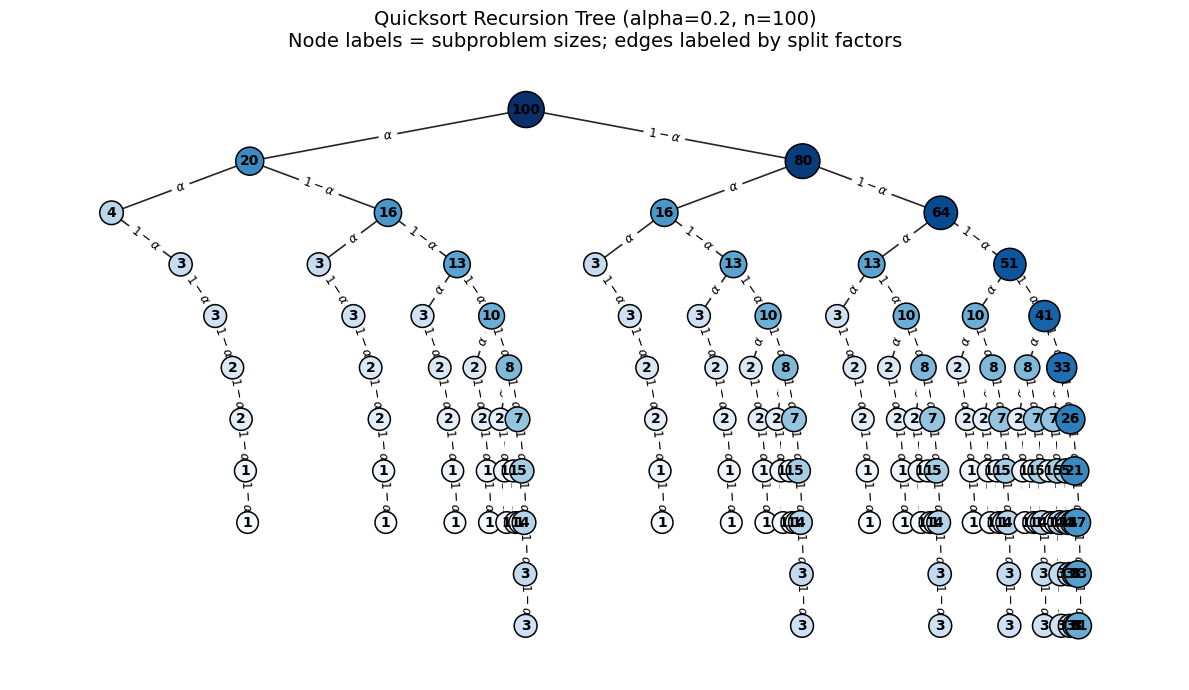

Nodes: 150, Edges: 149
Observed max depth: 10,   Rough bound ≈ log_(1/(1-0.2)) n = 20.64
(Tree truncated at depth 10 and min_size 1.0)


In [30]:
# Quicksort recursion tree visualization with fixed IDs and clean layout
# - No self-loops (unique node IDs)
# - Deterministic binary-tree layout
# - Edge labels: α and 1−α (as mathtext strings)
# - Stats with safe printing (no Greek letters as variable names)

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# -------------------- Parameters --------------------
alpha = 0.2         # balance parameter (left = alpha * size, right = (1-alpha) * size)
n0 = 100.0          # root size (float for clean decay)
max_depth = 10      # recursion depth cap
min_size = 1.0      # stop when subproblem size < min_size
annot_prec = 0      # decimals in node size labels
node_scale = 24     # base node size scaling for plotting

# -------------------- Graph + IDs --------------------
G = nx.DiGraph()
pos = {}            # node_id -> (x, y)
labels = {}         # node_id -> text label (size)
edge_labels = {}    # (u, v) -> r"$\alpha$" or r"$1-\alpha$"

_node_id_counter = 0
def new_id():
    """Return a fresh integer node id."""
    global _node_id_counter
    _node_id_counter += 1
    return _node_id_counter

# -------------------- Recursion tree builder --------------------
def add_subtree(size, depth, x_center, span, parent=None, edge_text=None):
    """
    Place a node at (x_center, -depth). Children at (x_center ± span/2, -(depth+1)).
    The horizontal 'span' halves each level to keep a tidy binary layout.
    """
    if depth > max_depth or size < min_size:
        return None

    nid = new_id()
    G.add_node(nid, size=size, depth=depth)
    pos[nid] = (x_center, -depth)
    labels[nid] = f"{size:.{annot_prec}f}"

    if parent is not None:
        G.add_edge(parent, nid)
        if edge_text is not None:
            edge_labels[(parent, nid)] = edge_text

    # Recurse
    left_size = alpha * size
    right_size = (1 - alpha) * size
    next_span = span / 2.0

    add_subtree(left_size,  depth + 1, x_center - next_span, next_span, nid, r"$\alpha$")
    add_subtree(right_size, depth + 1, x_center + next_span, next_span, nid, r"$1-\alpha$")

    return nid

# -------------------- Build the tree --------------------
root_id = add_subtree(
    size=n0,
    depth=0,
    x_center=0.0,
    span=2.0,          # initial horizontal span; tweak for wider/narrower tree
    parent=None,
    edge_text=None
)

# -------------------- Styling: colors/sizes --------------------
sizes = np.array([G.nodes[u]["size"] for u in G.nodes()])
# normalize log-sizes to [0,1] for coloring
cvals = np.log(np.maximum(sizes, 1e-9))
cvals = (cvals - cvals.min()) / (cvals.max() - cvals.min() + 1e-9)

# node size scaled gently by sqrt of size (visualizes decay without extremes)
node_sizes_draw = node_scale * (8 + 2*np.maximum(1, np.sqrt(sizes)))

# -------------------- Draw --------------------
plt.figure(figsize=(12, 7))
nx.draw_networkx_nodes(
    G, pos,
    node_color=cvals, cmap="Blues",
    node_size=node_sizes_draw,
    linewidths=1.1, edgecolors="black"
)
nx.draw_networkx_edges(G, pos, arrows=False, width=1.2, alpha=0.85)
nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_weight="bold")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.title(
    f"Quicksort Recursion Tree (alpha={alpha}, n={n0:.0f})\n"
    "Node labels = subproblem sizes; edges labeled by split factors",
    fontsize=14
)
plt.axis("off")
plt.tight_layout()
plt.show()

# -------------------- Stats / sanity checks --------------------
# Graph-theoretic depth from the root
sp = nx.shortest_path_length(G, source=root_id)
max_depth_tree = max(sp.values()) if len(sp) else 0
# Rough depth bound for repeatedly taking the larger side:
bound = np.log(max(n0, 1.0)) / np.log(1.0 / (1.0 - alpha))

print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
print(f"Observed max depth: {max_depth_tree},   Rough bound ≈ log_(1/(1-{alpha})) n = {bound:.2f}")
print(f"(Tree truncated at depth {max_depth} and min_size {min_size})")


---

# Pivot Selection

# Balanced-Split Probability in Quicksort

Think of Quicksort as a divide-and-conquer algorithm: it picks a **pivot** element, partitions the array around it (elements ≤ pivot go left, > pivot go right), and recurses on both sides. The "quality" of the split depends on how **balanced** it is—ideally, both sides have roughly equal sizes to minimize recursion depth.

## Step 1: Defining the Pivot Quantile and Balanced Splits

Let's start with the basics. Suppose we have an array of $n$ distinct elements, sorted for reference: $a_1 < a_2 < \dots < a_n$.

- The **pivot quantile** $X$ is the fraction of elements ≤ the pivot. In other words, if the pivot is the $k$-th smallest element, then $X = k/n$. So $X \in [0,1]$ (or more precisely, $X \in \{1/n, 2/n, \dots, 1\}$ for finite $n$).

- A split is **$\alpha$-balanced** if both sides have at least $\alpha n$ elements:
  - Left side (≤ pivot): at least $\alpha n$ elements → $X \geq \alpha$
  - Right side (> pivot): at least $\alpha n$ elements → $1 - X \geq \alpha$ → $X \leq 1 - \alpha$

  Thus, the "balanced band" is $X \in [\alpha, 1-\alpha]$, a middle interval of width $1 - 2\alpha$.

**Example**: For $n=100$, $\alpha=0.2$: Balanced if $X \in [0.2, 0.8]$ (at least 20 elements on each side).

Our goal: Compute $\Pr[X \in [\alpha, 1-\alpha]]$, the probability of a balanced split, for different pivot choices. We'll derive exact formulas and see their impact on Quicksort's running time.

---

## Part A: Random Pivot Selection

In the **random pivot** method, we pick any array element uniformly at random as the pivot. This is simple but can sometimes lead to bad (unbalanced) splits.

### A1: Discrete Case (Exact for Finite $n$)

Label the sorted elements by their **ranks**: 1 (smallest) to $n$ (largest). Picking a random pivot means choosing rank $I$ uniformly from $\{1, 2, \dots, n\}$.

- The split is $\alpha$-balanced if the left side has at least $\lceil \alpha n \rceil$ elements (including the pivot) and the right side has at least $\lceil \alpha n \rceil - 1$ (since pivot is on left). More precisely:
  - Left: $I \geq \lceil \alpha n \rceil$
  - Right: $n - I \geq \lceil \alpha n \rceil$ → $I \leq n - \lceil \alpha n \rceil = \lfloor (1 - \alpha)n \rfloor$ (adjusting for integer bounds)

  So, balanced iff $\lceil \alpha n \rceil \leq I \leq \lfloor (1 - \alpha)n \rfloor$.

- Number of favorable ranks: $\lfloor (1 - \alpha)n \rfloor - \lceil \alpha n \rceil + 1$

- Probability:
  $$
  \Pr[\text{balanced}] = \frac{\lfloor (1 - \alpha)n \rfloor - \lceil \alpha n \rceil + 1}{n} = 1 - 2\alpha + O\left(\frac{1}{n}\right)
  $$
  The $O(1/n)$ is a tiny "fencepost" error from rounding ceilings/floors.

**Worked Example**: $n=10$, $\alpha=0.3$ ($\alpha n = 3$, so $\lceil 3 \rceil = 3$, $\lfloor 7 \rfloor = 7$).
- Favorable $I$: 3 to 7 (5 values).
- $\Pr = 5/10 = 0.5$.
- Exact formula: $1 - 2(0.3) = 0.4$, close (error due to small $n$).

### A2: Continuous Approximation (Large-$n$ Limit)

For big $n$, treat ranks as continuous: $X \sim \mathrm{Uniform}(0,1)$ (every quantile equally likely).

- Probability of landing in the balanced band:
  $$
  \Pr[X \in [\alpha, 1-\alpha]] = \int_{\alpha}^{1-\alpha} 1 \, dx = (1 - \alpha) - \alpha = 1 - 2\alpha
  $$

**Intuition**: Imagine the [0,1] interval as a number line. Random pivot is like throwing a dart anywhere uniformly. The chance it hits the middle band of width $1-2\alpha$ is exactly that width—no more, no less.

**Visual Aid**: Picture a line from 0 to 1. Shade the middle $1-2\alpha$ portion. For $\alpha=0.2$, shade 0.6 of the line → 60% balanced chance.

**Key Takeaway for Random**: $\Pr[\text{balanced}] = 1 - 2\alpha$. Linear in the band width—simple, but extremes (e.g., $X < 0.1$) happen about 10% of the time.

---

## Part B: Median-of-3 Pivot Selection

**Median-of-3** improves balance: Pick 3 random elements, take their median as pivot. This "pulls" toward the center, reducing bad splits. (Extra cost: ~2 comparisons for the median, but worth it.)

We'll derive $\Pr[\text{balanced}] = 1 - 6\alpha^2 + 4\alpha^3$ in two ways: an intuitive combinatorial count (nearly discrete) and a clean calculus approach.

### B1: Combinatorial "Tail" Argument (Intuitive, Discrete-Friendly)

Assume large $n$, so the 3 samples are like i.i.d. draws from [0,1] quantiles (ignore replacement for simplicity; exact finite version converges as $n \to \infty$).

- Define **tails**: Left tail = [0, $\alpha$) (bad if too many here → small left side). Right tail = (1-$\alpha$, 1] (symmetric).
- Single-sample tail probability: $\alpha$ (left) or $\alpha$ (right).

- The median is **unbalanced** (outside [$\alpha$, 1-$\alpha$]) iff **at least 2 of the 3 samples are in the *same* tail**:
  - If ≥2 in left tail, median ≤ left tail's max < $\alpha$.
  - Similarly for right.

- Probability ≥2 in left tail (binomial: 3 trials, success prob $\alpha$):
  - Exactly 2: $\binom{3}{2} \alpha^2 (1-\alpha) = 3\alpha^2 (1-\alpha)$
  - Exactly 3: $\binom{3}{3} \alpha^3 = \alpha^3$
  - Total: $3\alpha^2 (1-\alpha) + \alpha^3 = 3\alpha^2 - 3\alpha^3 + \alpha^3 = 3\alpha^2 - 2\alpha^3$

- By symmetry, same for right tail: another $3\alpha^2 - 2\alpha^3$.
- Total $\Pr[\text{unbalanced}] = 2(3\alpha^2 - 2\alpha^3) = 6\alpha^2 - 4\alpha^3$.

- Thus:
  $$
  \boxed{\Pr[\text{balanced}] = 1 - 6\alpha^2 + 4\alpha^3}
  $$

**Finite-$n$ Note**: Let $\ell = \lfloor \alpha n \rfloor$ (left tail size).
$$
\Pr[\geq 2 \text{ from left}] = \frac{\binom{\ell}{2}\binom{n-\ell}{1} + \binom{\ell}{3}}{\binom{n}{3}}
$$
Double for right tail. As $n \to \infty$, $\ell/n \to \alpha$, it matches the continuous formula.

**Worked Example**: $\alpha=0.2$.
- Random: $1 - 2(0.2) = 0.6$
- Median-of-3: $1 - 6(0.04) + 4(0.008) = 1 - 0.24 + 0.032 = 0.792$ (32% better!).

**Intuition**: With 3 samples, it's harder for the median to stray far—needs 2+ in one tail. This quadratic/cubic suppression makes extremes rare.

### B2: Continuous Order-Statistics (Calculus Derivation)

Let $U_1, U_2, U_3 \stackrel{\text{iid}}{\sim} \mathrm{Uniform}(0,1)$. The pivot is $Y = \text{median}\{U_1, U_2, U_3\}$.

- Order them: $U_{(1)} < U_{(2)} < U_{(3)}$, so $Y = U_{(2)}$.
- Density of the 2nd order statistic (for 3 uniforms): $f_Y(y) = 3! \cdot y \cdot (1-y) \cdot 1^2 = 6y(1-y)$ for $y \in [0,1]$. (Beta(2,2) distribution.)

- Balanced probability:
  $$
  \Pr[Y \in [\alpha, 1-\alpha]] = \int_{\alpha}^{1-\alpha} 6y(1-y) \, dy
  $$
  Antiderivative: $\int 6y - 6y^2 \, dy = 3y^2 - 2y^3$.

  Evaluate:
  $$
  \left[3y^2 - 2y^3\right]_{\alpha}^{1-\alpha} = \Big(3(1-\alpha)^2 - 2(1-\alpha)^3\Big) - \Big(3\alpha^2 - 2\alpha^3\Big)
  $$
  
  Expand top:
  
  $$
  \begin{aligned}
  3(1 - 2\alpha + \alpha^2) - 2(1 - 3\alpha + 3\alpha^2 - \alpha^3)\\
   = 3 - 6\alpha + 3\alpha^2 - 2 + 6\alpha - 6\alpha^2 + 2\alpha^3 \\
   = 1 - 3\alpha^2 + 2\alpha^3
   \end{aligned}
   $$

  Bottom: $3\alpha^2 - 2\alpha^3$

  Total: $1 - 3\alpha^2 + 2\alpha^3 - 3\alpha^2 + 2\alpha^3 = 1 - 6\alpha^2 + 4\alpha^3$.

**Intuition**: The Beta(2,2) density $6y(1-y)$ is a hill-shaped curve, peaking at 0.5 (1.5 max). It assigns higher probability to central values, "pulling" $Y$ inward vs. uniform.

**Visual Aid**: Uniform is flat; Beta(2,2) is parabolic, symmetric around 0.5. Integrate under the curve from $\alpha$ to $1-\alpha$.

**Key Takeaway for Median-of-3**: Starts at 1 (when $\alpha=0$), rises faster than linear (e.g., at $\alpha=0.5$, it's 1 vs. 0 for random). Suppresses skews quadratically.

---

## Part C: Connecting to Quicksort's Running Time Constant

Now, how does balance affect efficiency? Quicksort's average time is $T(n) \approx a n \ln n + O(n)$, where $a$ is the **leading constant** we care about.

### Step C1: The Average-Case Formula

From recurrence analysis (summing over pivot positions):
$$
T(n) = a n \ln n + O(n), \quad a = \frac{c_p + c_s}{\mathbb{E}\big[-X \ln X - (1-X) \ln(1-X)\big]}
$$
- $c_p$: Comparisons per element during partition (≈1-2 in practice).
- $c_s$: Amortized cost of pivot selection per element (0 for random, small constant for median-of-3).
- Denominator: **Binary entropy** of $X$ (bits needed to specify split). Larger when $X$ is concentrated near 0.5 (balanced splits → deeper, bushier tree → more work per level, but wait—no: actually, it normalizes the recursion cost. Higher entropy means "worse" average balance, larger $a$).

Intuition: The entropy term measures "average imbalance." Better balance (smaller variance in $X$) → larger denominator → smaller $a$ → faster runtime.

### Step C2: Compute for Random Pivot

$X \sim \mathrm{Uniform}(0,1)$:
$$
\mathbb{E}[-X \ln X - (1-X) \ln(1-X)] = 2 \int_0^{0.5} -x \ln x \, dx = \frac{1}{2} \quad (\text{symmetric, standard integral})
$$
Ignore $c_s$: If $c_p \approx 1$, $a \approx 2$. So $T(n) \approx 2 n \ln n \approx 1.386 n \log_2 n$.

### Step C3: Compute for Median-of-3

$Y \sim \mathrm{Beta}(2,2)$. The expectation requires digamma functions:
$$
\mathbb{E}[-Y \ln Y - (1-Y) \ln(1-Y)] = \psi(5) - \psi(3) = \frac{7}{12} \approx 0.5833
$$
(Where $\psi(k) = -\gamma + H_{k-1}$, harmonic numbers; you can verify numerically.)

With $c_p \approx 1$, $a \approx 1 / (7/12) = 12/7 \approx 1.714$. So $T(n) \approx 1.714 n \ln n \approx 1.188 n \log_2 n$ (14% faster than random!).

**Including $c_s$**: Median-of-3 adds ~2/3 comparisons per element for selection, bumping $c_s \approx 2/3$, so $a \approx (1 + 2/3) / (7/12) \approx 2.0$—still a win in practice.

### Step C4: Why the Improvement?

- Random: Linear prob $1-2\alpha$ → 20% chance of $\alpha=0.1$ skew.
- Median-of-3: Cubic $1-6\alpha^2 + 4\alpha^3$ → only ~6% for same $\alpha$.

Tighter balance → higher entropy denominator → lower $a$. The tiny selection overhead is dwarfed by fewer deep recursions.

**Bottom Line**: Random is easy but risky; median-of-3 is a cheap upgrade for real-world arrays. Experiment in code to see the speedup!

Questions? Try deriving for median-of-5 (hint: Beta(3,3)) or simulate in Python.

<>:20: SyntaxWarning: invalid escape sequence '\;'
<>:20: SyntaxWarning: invalid escape sequence '\;'
/var/folders/4_/351wz59j4wd2fvwy3hb4c30r0000gn/T/ipykernel_84106/1571358638.py:20: SyntaxWarning: invalid escape sequence '\;'
  plt.title("Probability of $\;\\alpha$-balanced split vs. pivot strategy")


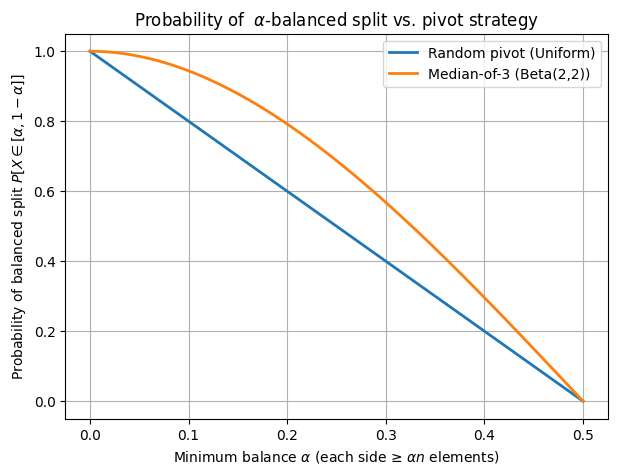

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# --- Parameters --------------------------------------------------------------
alphas = np.linspace(0, 0.5, 200)

# Random pivot: P(balanced) = 1 - 2*alpha
p_bal_random = 1 - 2*alphas

# Median-of-3 pivot: X ~ Beta(2,2), P(balanced) = 1 - 6a^2 + 4a^3
p_bal_med3 = 1 - 6*alphas**2 + 4*alphas**3

# --- Plot --------------------------------------------------------------------
plt.figure(figsize=(7,5))
plt.plot(alphas, p_bal_random, label="Random pivot (Uniform)", lw=2)
plt.plot(alphas, p_bal_med3, label="Median-of-3 (Beta(2,2))", lw=2)
plt.xlabel(r"Minimum balance $\alpha$ (each side ≥ $\alpha n$ elements)")
plt.ylabel(r"Probability of balanced split $P[X\in[\alpha,1-\alpha]]$")
plt.title("Probability of $\;\\alpha$-balanced split vs. pivot strategy")
plt.legend()
plt.grid(True)
plt.show()


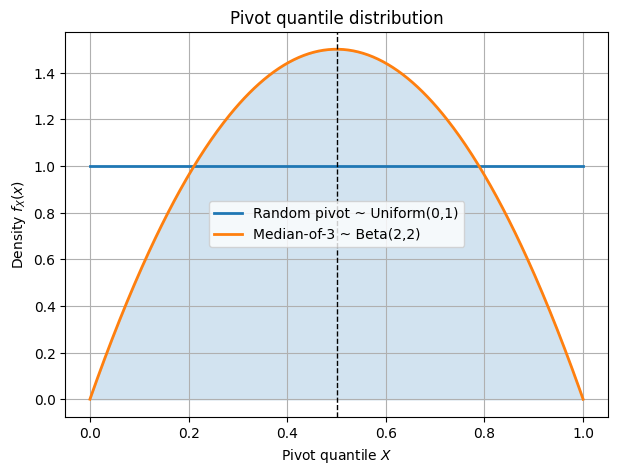

In [4]:
x = np.linspace(0, 1, 400)
plt.figure(figsize=(7,5))
plt.plot(x, np.ones_like(x), label="Random pivot ~ Uniform(0,1)", lw=2)
plt.plot(x, beta.pdf(x, 2, 2), label="Median-of-3 ~ Beta(2,2)", lw=2)
plt.fill_between(x, 0, beta.pdf(x, 2, 2), color="tab:blue", alpha=0.2)
plt.axvline(0.5, color="k", ls="--", lw=1)
plt.xlabel("Pivot quantile $X$")
plt.ylabel("Density $f_X(x)$")
plt.title("Pivot quantile distribution")
plt.legend()
plt.grid(True)
plt.show()


For n=1000, α=0.2:
Random - Analytical: 0.6000
Random - Exact Discrete: 0.6010
Random - Simulated: 0.5994
Median-of-3 - Analytical: 0.7920
Median-of-3 - Simulated: 0.7934


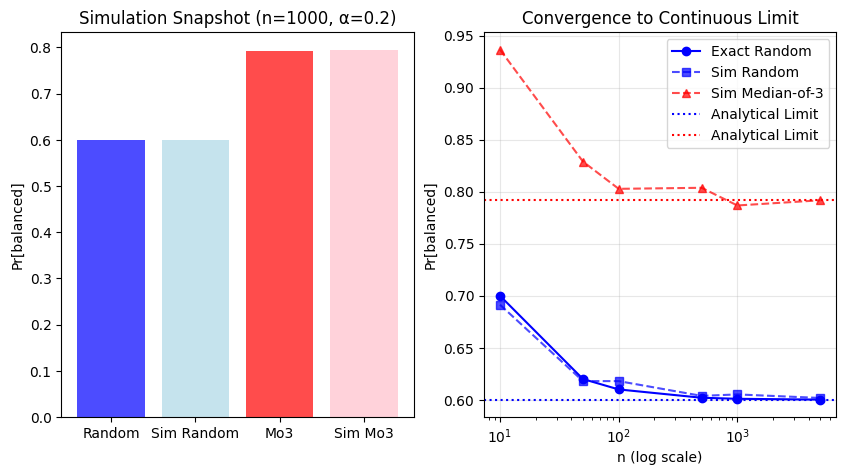

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb  # For exact finite calc

def exact_random_prob(n, alpha):
    """Exact discrete Pr[balanced] for random pivot."""
    left = np.ceil(alpha * n).astype(int)
    right = np.floor((1 - alpha) * n).astype(int)
    favorable = max(0, right - left + 1)
    return favorable / n

def simulate_random(n, alpha, trials=10000):
    """Monte Carlo for random pivot."""
    left = np.ceil(alpha * n).astype(int)
    right = np.floor((1 - alpha) * n).astype(int)
    balanced = sum(1 for _ in range(trials) if left <= np.random.randint(1, n+1) <= right)
    return balanced / trials

def simulate_median3(n, alpha, trials=10000):
    """Monte Carlo for median-of-3 (sample without replacement)."""
    balanced = 0
    for _ in range(trials):
        # Sample 3 distinct indices (ranks 1 to n)
        samples = np.random.choice(n, 3, replace=False) + 1  # Ranks 1..n
        pivot_rank = np.median(samples)
        left = np.ceil(alpha * n).astype(int)
        right = np.floor((1 - alpha) * n).astype(int)
        if left <= pivot_rank <= right:
            balanced += 1
    return balanced / trials

# Parameters
n = 1000  # Try smaller n=10 for worked example
alpha = 0.2
trials = 10000

# Compute
p_exact_random = exact_random_prob(n, alpha)
p_sim_random = simulate_random(n, alpha, trials)
p_sim_median3 = simulate_median3(n, alpha, trials)
p_analytical_random = 1 - 2 * alpha
p_analytical_median3 = 1 - 6 * alpha**2 + 4 * alpha**3

# Print results
print(f"For n={n}, α={alpha}:")
print(f"Random - Analytical: {p_analytical_random:.4f}")
print(f"Random - Exact Discrete: {p_exact_random:.4f}")
print(f"Random - Simulated: {p_sim_random:.4f}")
print(f"Median-of-3 - Analytical: {p_analytical_median3:.4f}")
print(f"Median-of-3 - Simulated: {p_sim_median3:.4f}")

# Bonus Plot: Convergence vs. n
ns = [10, 50, 100, 500, 1000, 5000]
p_sim_r = [simulate_random(nn, alpha, trials=5000) for nn in ns]  # Fewer trials for speed
p_exact_r = [exact_random_prob(nn, alpha) for nn in ns]
p_sim_m3 = [simulate_median3(nn, alpha, trials=5000) for nn in ns]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(['Random', 'Sim Random', 'Mo3', 'Sim Mo3'],
        [p_analytical_random, p_sim_random, p_analytical_median3, p_sim_median3],
        color=['blue', 'lightblue', 'red', 'pink'], alpha=0.7)
plt.ylabel('Pr[balanced]')
plt.title(f'Simulation Snapshot (n={n}, α={alpha})')

plt.subplot(1, 2, 2)
plt.semilogx(ns, p_exact_r, 'b-o', label='Exact Random')
plt.semilogx(ns, p_sim_r, 'b--s', label='Sim Random', alpha=0.7)
plt.semilogx(ns, p_sim_m3, 'r--^', label='Sim Median-of-3', alpha=0.7)
plt.axhline(p_analytical_random, color='blue', linestyle=':', label='Analytical Limit')
plt.axhline(p_analytical_median3, color='red', linestyle=':', label='Analytical Limit')
plt.xlabel('n (log scale)')
plt.ylabel('Pr[balanced]')
plt.title('Convergence to Continuous Limit')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Hybrid Quicksort–Insertion Sort Crossover Depth

### 1. Setting up the cost models

Let the average running times be:

$$
T_Q(n) \approx a, n \log_2 n, \qquad T_I(n) \approx b, n^2
$$

where
$ a $ is the constant factor for Quicksort (partition + recursion overhead), and
$ b $ is the constant factor for Insertion Sort (simple comparison/swap operations).

At small $ n $, constant factors dominate, so we want to find when Insertion Sort becomes faster.

---

### 2. Defining the crossover point

We switch to insertion sort when its cost becomes less than Quicksort’s:

$$
T_I(k) \le T_Q(k)
$$

Substituting the models:

$$
b,k^2 = a,k \log_2 k
$$

Simplifying:

$$
k = \frac{a}{b} \log_2 k
$$

This transcendental equation defines the **crossover size** $ k^* $.

---

### 3. Approximating the crossover size

Rearrange:

$$
\frac{k}{\log_2 k} = \frac{a}{b}
$$

The ratio $ a/b $ expresses how much more expensive Quicksort’s overhead is compared to Insertion Sort’s inner loop.
Empirical measurements show $ a/b \in [10, 30] $.

We can tabulate rough values:

| $k$ | $k / \log_2 k$ |
| --- | -------------- |
| 10  | 3.3            |
| 20  | 5.9            |
| 30  | 8.5            |
| 40  | 11.5           |
| 50  | 14.1           |
| 100 | 21.7           |

So for $ a/b \approx 10–20 $, the equality holds around $ k \approx 30–50 $.

Therefore, the **optimal switch threshold** is roughly:

$$
k^* \in [30, 50]
$$

---

### 4. Interpreting as recursion depth

Quicksort divides the array recursively, so subarrays of size $ k $ appear at depth $ d^* $ such that:

$$
n , 2^{-d^*} = k \quad \Longrightarrow \quad d^* = \log_2 \frac{n}{k}
$$

For example, with $ n = 1024 $ and $ k = 32 $:

$$
d^* = \log_2 1024 - \log_2 32 = 10 - 5 = 5
$$

Thus, it becomes efficient to switch to insertion sort **after about 5 recursive levels**.

---

### 5. Summary

1. Assume average costs:
   $ T_Q(n) = a n \log n $ and $ T_I(n) = b n^2 $
2. Equate:
   $ a n \log n = b n^2 $
3. Solve:
   $ k = (a/b) \log k $
4. Estimate:
   $ k^* \approx 30–50 $
5. Depth of switch:
   $ d^* = \log_2 (N / k^*) $